In [37]:
import git
from git import Repo

from unidiff import PatchSet

import subprocess
import json
import pandas as pd
import numpy as np
import matplotlib
import sys
import matplotlib.pyplot as plt
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import ExtraTreesClassifier

In [41]:
mutants_and_tests = pd.read_pickle('flask_full_with_edit_distances.pkl')
len(mutants_and_tests)
display(mutants_and_tests)
print(mutants_and_tests.columns)

,mutant_id,current_line,line_number_changed,modified_file_path,modified_method,previous_line,repo_path,outcome,test_id,full_name,name,filepath,duration,setup_outcome,setup_duration,call_outcome,call_duration,teardown_outcome,teardown_duration,edit_distance_method_name_test_name
0,1873.0,debug = None,841.0,src/flask/cli.py,run_command,,/tmp/tmpszy15usp,True,0.0,tests/test_appctx.py::test_basic_url_generation,test_basic_url_generation,tests/test_appctx.py,0.059266,True,0.029150,True,0.000706,True,0.000260,11
1,1873.0,debug = None,841.0,src/flask/cli.py,run_command,,/tmp/tmpszy15usp,True,1.0,tests/test_appctx.py::test_url_generation_requ...,test_url_generation_requires_server_name,tests/test_appctx.py,0.003147,True,0.001320,True,0.000298,True,0.000208,11
2,1873.0,debug = None,841.0,src/flask/cli.py,run_command,,/tmp/tmpszy15usp,True,2.0,tests/test_appctx.py::test_url_generation_with...,test_url_generation_without_context_fails,tests/test_appctx.py,0.000988,True,0.000293,True,0.000176,True,0.000225,11
3,1873.0,debug = None,841.0,src/flask/cli.py,run_command,,/tmp/tmpszy15usp,True,3.0,tests/test_appctx.py::test_request_context_mea...,test_request_context_means_app_context,tests/test_appctx.py,0.003678,True,0.001334,True,0.000801,True,0.000208,11
4,1873.0,debug = None,841.0,src/flask/cli.py,run_command,,/tmp/tmpszy15usp,True,4.0,tests/test_appctx.py::test_app_context_provide...,test_app_context_provides_current_app,tests/test_appctx.py,0.003005,True,0.001300,True,0.000202,True,0.000202,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
958036,1040.0,if self.session_interface.is_null_sess...,2174.0,src/flask/app.py,process_response,,/tmp/tmpsuxyyqwi,True,463.0,tests/test_views.py::test_explicit_head,test_explicit_head,tests/test_views.py,0.005060,True,0.001630,True,0.001569,True,0.000230,16
958037,1040.0,if self.session_interface.is_null_sess...,2174.0,src/flask/app.py,process_response,,/tmp/tmpsuxyyqwi,True,464.0,tests/test_views.py::test_endpoint_override,test_endpoint_override,tests/test_views.py,0.005697,True,0.001254,True,0.002970,True,0.000220,16
958038,1040.0,if self.session_interface.is_null_sess...,2174.0,src/flask/app.py,process_response,,/tmp/tmpsuxyyqwi,True,465.0,tests/test_views.py::test_methods_var_inheritance,test_methods_var_inheritance,tests/test_views.py,0.004606,True,0.001403,True,0.001572,True,0.000228,16
958039,1040.0,if self.session_interface.is_null_sess...,2174.0,src/flask/app.py,process_response,,/tmp/tmpsuxyyqwi,True,466.0,tests/test_views.py::test_multiple_inheritance,test_multiple_inheritance,tests/test_views.py,0.004516,True,0.001343,True,0.001601,True,0.000228,16


Index(['mutant_id', 'current_line', 'line_number_changed',
       'modified_file_path', 'modified_method', 'previous_line', 'repo_path',
       'outcome', 'test_id', 'full_name', 'name', 'filepath', 'duration',
       'setup_outcome', 'setup_duration', 'call_outcome', 'call_duration',
       'teardown_outcome', 'teardown_duration',
       'edit_distance_method_name_test_name'],
      dtype='object')


# Data Preparation

In [42]:
feature_columns = ["edit_distance_method_name_test_name", "current_line", "line_number_changed", "modified_file_path", "previous_line", "test_id", "name", "filepath", "modified_method"]
#feature_columns = ["current_line", "line_number_changed", "modified_file_path", "previous_line", "test_id", "name", "filepath"]
X = mutants_and_tests[feature_columns]
y = mutants_and_tests["outcome"]

# Throw out nan values:
X = X.loc[mutants_and_tests[feature_columns].isnull().any(axis=1) == False]
y = mutants_and_tests["outcome"].loc[mutants_and_tests[feature_columns].isnull().any(axis=1) == False]
y = y.astype('bool')
len(X)


920088

In [43]:
# Encode stuff we want to encode:
encoded_columns = ["modified_method", "modified_file_path", "name", "filepath", "current_line", "previous_line"]
# encoded_columns = ["name", "filepath", "modified_file_path", "current_line", "previous_line"]
# Encoding
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
X_enc = enc.fit_transform(X[encoded_columns])
i = 0
for column_name in encoded_columns:
    X[column_name] = X_enc[:,i]
    i += 1
X

,edit_distance_method_name_test_name,current_line,line_number_changed,modified_file_path,previous_line,test_id,name,filepath,modified_method
0,11,1307.0,841.0,2.0,0.0,0.0,116.0,0.0,189.0
1,11,1307.0,841.0,2.0,0.0,1.0,602.0,0.0,189.0
2,11,1307.0,841.0,2.0,0.0,2.0,603.0,0.0,189.0
3,11,1307.0,841.0,2.0,0.0,3.0,501.0,0.0,189.0
4,11,1307.0,841.0,2.0,0.0,4.0,102.0,0.0,189.0
...,...,...,...,...,...,...,...,...,...
958036,16,766.0,2174.0,0.0,0.0,463.0,216.0,17.0,175.0
958037,16,766.0,2174.0,0.0,0.0,464.0,196.0,17.0,175.0
958038,16,766.0,2174.0,0.0,0.0,465.0,278.0,17.0,175.0
958039,16,766.0,2174.0,0.0,0.0,466.0,282.0,17.0,175.0


In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=420, shuffle=False)
X_train

,edit_distance_method_name_test_name,current_line,line_number_changed,modified_file_path,previous_line,test_id,name,filepath,modified_method
0,11,1307.0,841.0,2.0,0.0,0.0,116.0,0.0,189.0
1,11,1307.0,841.0,2.0,0.0,1.0,602.0,0.0,189.0
2,11,1307.0,841.0,2.0,0.0,2.0,603.0,0.0,189.0
3,11,1307.0,841.0,2.0,0.0,3.0,501.0,0.0,189.0
4,11,1307.0,841.0,2.0,0.0,4.0,102.0,0.0,189.0
...,...,...,...,...,...,...,...,...,...
650640,9,813.0,133.0,7.0,0.0,97.0,627.0,1.0,111.0
650641,9,813.0,133.0,7.0,0.0,98.0,618.0,1.0,111.0
650642,9,813.0,133.0,7.0,0.0,99.0,617.0,1.0,111.0
650643,9,813.0,133.0,7.0,0.0,100.0,616.0,1.0,111.0


In [45]:
# Decision Tree
from sklearn import tree
clf = tree.DecisionTreeClassifier(ccp_alpha=0.001)
clf.fit(X_train, y_train)

print(y_train.value_counts())
print(y_test.value_counts())
print(classification_report(y_test, clf.predict(X_test)))

True     573303
False     43155
Name: outcome, dtype: int64
True     265942
False     37688
Name: outcome, dtype: int64
              precision    recall  f1-score   support

       False       0.68      0.18      0.28     37688
        True       0.89      0.99      0.94    265942

    accuracy                           0.89    303630
   macro avg       0.79      0.58      0.61    303630
weighted avg       0.87      0.89      0.86    303630



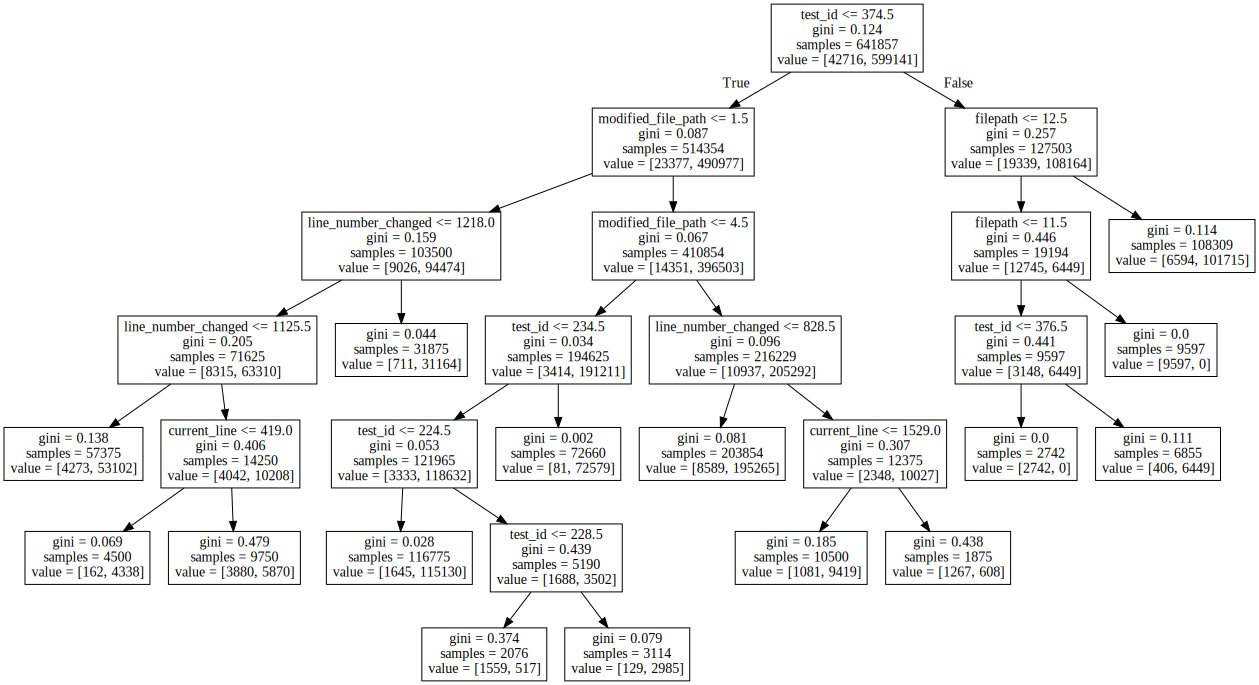

In [18]:
from graphviz import Source
from IPython.display import SVG
graph = Source(tree.export_graphviz(clf, out_file=None, feature_names=X.columns))
SVG(graph.pipe(format='svg'))

True     573303
False     43155
Name: outcome, dtype: int64
True     265942
False     37688
Name: outcome, dtype: int64
              precision    recall  f1-score   support

       False       0.78      0.28      0.42     37688
        True       0.91      0.99      0.95    265942

    accuracy                           0.90    303630
   macro avg       0.84      0.64      0.68    303630
weighted avg       0.89      0.90      0.88    303630

Feature ranking:
1. feature 5: edit_distance_method_name_test_name (0.223366)
2. feature 1: current_line (0.184627)
3. feature 6: line_number_changed (0.174496)
4. feature 7: modified_file_path (0.163250)
5. feature 2: previous_line (0.157552)
6. feature 8: test_id (0.038307)
7. feature 3: name (0.035519)
8. feature 0: filepath (0.022883)
9. feature 4: modified_method (0.000000)


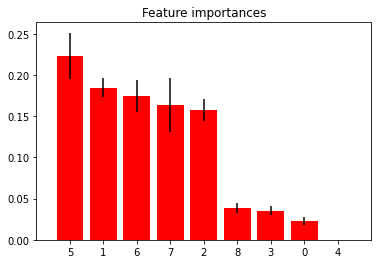

In [46]:
# Forest
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=420)

forest.fit(X_train, y_train)

print(y_train.value_counts())
print(y_test.value_counts())
print(classification_report(y_test, forest.predict(X_test)))

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d: %s (%f)" % (f + 1, indices[f], X.columns[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

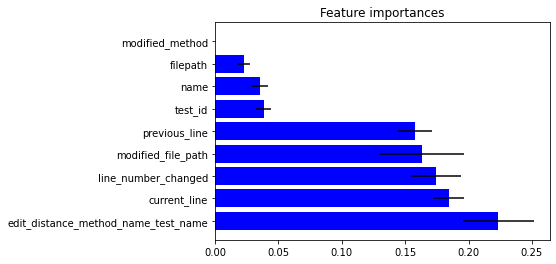

In [47]:
# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.barh(range(X.shape[1]), importances[indices],
        color="blue", xerr=std[indices], align="center")
plt.yticks(range(X.shape[1]), X.columns)
#plt.xlim([-1, X.shape[1]])
plt.show()